# 4.2 Detection of Pretrained obejct

# installing pycotools

In [7]:
pip install pycotools


  Created wheel for pycotools: filename=pycotools-1.0.10-py3-none-any.whl size=181394 sha256=2164610d793f91e5a9b6b720e89ec54fed7aee4ffa2e13efe31db4701a77921f
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\09\1a\f8\c7d85e1fc868944babc7e1f144a5e54b8e45724da37b3a513a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=bd02eebef877f802eaf436240d89fa97787cb11c0f98a91416f4db6fa4616d4f
  Stored in directory: c:\users\admin\appdata\local\pip\cache\wheels\14\25\f7\1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pycotools sklearn


# importing required libraries

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import skimage.io as io
import os

# importing coco

In [18]:
!pip install -q pycocotools
from pycocotools.coco import COCO

In [21]:
img_dir=('D:/coco_minitrain_25k/coco_minitrain_25k/images/val2017/')
annotations_file='D:/coco_minitrain_25k/coco_minitrain_25k/annotations/instances_val2017.json'

In [22]:
coco=COCO(annotations_file)

loading annotations into memory...
Done (t=2.38s)
creating index...
index created!


In [23]:
imgIds = coco.getImgIds()
print("Total images: {}".format(len(imgIds)))
rand=np.random.randint(0,len(imgIds))
img = coco.loadImgs(imgIds[rand])[0]
print("Image example:")
print(img)
annIds=coco.getAnnIds()
print("\nTotal annotations: {}".format(len(annIds)))
ann=coco.loadAnns(coco.getAnnIds(imgIds=img['id']))
print("Annotation example:")
print(ann[0])

Total images: 5000
Image example:
{'license': 1, 'file_name': '000000494869.jpg', 'coco_url': 'http://images.cocodataset.org/val2017/000000494869.jpg', 'height': 640, 'width': 427, 'date_captured': '2013-11-14 18:46:11', 'flickr_url': 'http://farm9.staticflickr.com/8255/8713396144_ea7d431000_z.jpg', 'id': 494869}

Total annotations: 36781
Annotation example:
{'segmentation': [[0.0, 503.5, 21.89, 490.62, 37.34, 467.44, 56.66, 455.86, 60.52, 448.13, 72.11, 439.11, 74.69, 432.68, 87.57, 421.09, 103.02, 422.37, 115.9, 430.1, 123.62, 437.83, 135.21, 440.4, 139.07, 449.42, 135.21, 454.57, 124.91, 467.44, 117.18, 467.44, 113.32, 475.17, 113.32, 491.91, 112.03, 500.93, 121.05, 491.91, 133.92, 491.91, 135.21, 485.47, 142.94, 485.47, 142.94, 491.91, 154.53, 490.62, 153.24, 504.79, 141.65, 508.65, 126.2, 522.82, 117.18, 536.98, 109.46, 546.0, 95.29, 540.85, 82.41, 543.42, 72.11, 556.3, 57.95, 571.75, 70.82, 591.07, 52.8, 621.97, 34.77, 629.7, 16.74, 628.41, 1.29, 627.12, 2.58, 513.8]], 'area': 16

In [24]:
cats = coco.loadCats(coco.getCatIds())
print("Number of categories: {}".format(len(cats)))
nms=[cat['name'] for cat in cats]
print('\nCOCO categories: \n{}\n'.format(' '.join(nms)))

Number of categories: 80

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush



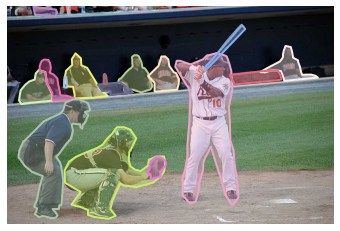

In [32]:
I = io.imread(img['coco_url'])
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [27]:

os.mkdir('D:/coco_minitrain_25k/coco_minitrain_25k/val_tfrecords/')


records_path=('D:/coco_minitrain_25k/coco_minitrain_25k/val_tfrecords/')

In [28]:
def get_annotations(imgId):
    annIds=coco.getAnnIds(imgIds=imgId)
    anns=coco.loadAnns(annIds)
    segmentations=[]
    segmentation_lengths=[]
    bboxes=[]
    catIds=[]
    iscrowd_list=[]
    area_list=[]
    annotation_ids=[]
    for ann in anns:
        try:
            catId=ann['category_id']
            bbox=ann['bbox']
            segmentation=ann['segmentation'][0]
            iscrowd=ann['iscrowd']
            area=ann['area']
            annotation_id=ann['id']
        except:
            continue
        if((not None in bbox) and (None!=catId)):
            catIds.append(catId)
            segmentations.append(segmentation)
            segmentation_lengths.append(len(segmentation))
            bboxes.append(bbox)
            iscrowd_list.append(iscrowd)
            area_list.append(area)
            annotation_ids.append(annotation_id)
    return len(anns),catIds,segmentation_lengths,sum(segmentations,[]),sum(bboxes,[]),iscrowd_list,area_list,annotation_ids

In [37]:
n=len(imgIds)
imgids=imgIds[0:n]
size=0
for i in imgids:
    img=coco.loadImgs(i)
    fn=img[0]['file_name']
    size+=os.path.getsize(img_dir+fn)
avg_size=size/n
limit=int(104857600//avg_size)
total_tfrecords=int(len(imgIds)//limit)
print("{} TFRecord files will be created".format(total_tfrecords))

for i in range(0,total_tfrecords):
    examples=[]
    start=i*limit
    end=start+limit
    imgids=imgIds[start:end]
    
    for img in coco.loadImgs(imgids):
        with open(str(img_dir)+img['file_name'],'rb') as f:
            image_string=f.read()

        objects,catIds,segmentation_lengths,segmentations,bboxes,iscrowd,area,annotation_ids=get_annotations(img['id'])

        # Create a Features message using tf.train.Example.
        example = tf.train.Example(features=tf.train.Features(feature={
            'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_string])),
            'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['height']])),
            'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['width']])),
            'id': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['id']])),
            'license': tf.train.Feature(int64_list=tf.train.Int64List(value=[img['license']])),
            'file_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['file_name'])])),
            'coco_url': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['coco_url'])])),
            'flickr_url': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['flickr_url'])])),
            'date_captured': tf.train.Feature(bytes_list=tf.train.BytesList(value=[tf.compat.as_bytes(img['date_captured'])])),
            #objects-Number of objects in the image
            'objects': tf.train.Feature(int64_list=tf.train.Int64List(value=[objects])),
            #Follwing features hold all the annotations data given for the image
            #category_ids-List of aannotation category ids
            'category_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=catIds)),
            #segmentation_lengths-List of segmentation lengths
            'segmentation_lengths': tf.train.Feature(int64_list=tf.train.Int64List(value=segmentation_lengths)),
            #segmention lists flattened into 1D list
            'segmentations': tf.train.Feature(float_list=tf.train.FloatList(value=segmentations)),
            #bboxes flattened into 1D list
            'bboxes': tf.train.Feature(float_list=tf.train.FloatList(value=bboxes)),
            #List of iscrowd values
            'iscrowd': tf.train.Feature(int64_list=tf.train.Int64List(value=iscrowd)),
            #List of area values
            'area': tf.train.Feature(float_list=tf.train.FloatList(value=area)),
            #List of annotation ids 
            'annotation_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=annotation_ids)),
        }))
        examples.append(example)
    
    with tf.io.TFRecordWriter(records_path+'coco'+str(i)+'.tfrecord') as writer:
        for j in examples:
            writer.write(j.SerializeToString())
    examples.clear()
    print("file {} created".format(i))

7 TFRecord files will be created
file 0 created
file 1 created
file 2 created
file 3 created
file 4 created
file 5 created
file 6 created


In [38]:
def parse(feature):
    features = tf.io.parse_single_example(
        feature,
        features={
        'image': tf.io.FixedLenFeature([], tf.string),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'id': tf.io.FixedLenFeature([], tf.int64),
        'license': tf.io.FixedLenFeature([], tf.int64),
        'file_name': tf.io.FixedLenFeature([], tf.string),
        'coco_url': tf.io.FixedLenFeature([], tf.string),
        'flickr_url': tf.io.FixedLenFeature([], tf.string),
        'date_captured': tf.io.FixedLenFeature([], tf.string),
        'objects': tf.io.FixedLenFeature([], tf.int64),
        'category_ids': tf.io.VarLenFeature(tf.int64),
        'segmentation_lengths': tf.io.VarLenFeature(tf.int64),
        'segmentations': tf.io.VarLenFeature(tf.float32),
        'bboxes': tf.io.VarLenFeature(tf.float32),
        'iscrowd': tf.io.VarLenFeature(tf.int64),
        'area': tf.io.VarLenFeature(tf.float32),
        'annotation_ids': tf.io.VarLenFeature(tf.int64),
        
    })

    
    print('Image id:')
    print(features['id'])
    print('\nlicense:')
    print(features['license'])
    print('\nfile_name:')
    print(features['file_name'])
    print('\ncoco_url:')
    print(features['coco_url'])
    print('\nflickr_url:')
    print(features['flickr_url'])
    print('\ndate_captured:')
    print(features['date_captured'])
    print("\nobjects:")
    print(features['objects'])
    print("\nheight:")
    print(features['height'])
    print("\nwidth:")
    print(features['width'])
    print("\ncategory ids:")
    print(features['category_ids'])
    print("\niscrowd:")
    print(features['iscrowd'])
    print("\narea:")
    print(features['area'])
    print("\nannotation_ids:")
    print(features['annotation_ids'])
    
    
    
    objects = features['objects']
    bboxes = features['bboxes']
    bboxes = tf.sparse.to_dense(bboxes)
    bboxes = tf.reshape(bboxes, [objects, 4])
    
    print("\nbboxes:")
    print(bboxes)
    
    print("\nsegmentation lengths:")
    print(features['segmentation_lengths'])
    
    segmentations = features['segmentations']
    segmentations = tf.sparse.to_dense(segmentations)
    segmentation_lengths=tf.sparse.to_dense(features['segmentation_lengths'])
    

    segs=[]
    start=0
    for i in segmentation_lengths:
        segs.append(tf.slice(segmentations,[start,],[i,]))
        start+=i
    print("\nSegmentations:")    
    print(segs)
    
    image = tf.image.decode_jpeg(features['image'], channels=3)
    plt.imshow(image); plt.axis('off')
    
    anns=[]
    for i in range(0,len(segs)):
        #plt.gca().add_patch(Rectangle((i[0],i[1]),i[2],i[3],linewidth=1,edgecolor='r',facecolor='none'))
        ann={}
        ann['segmentation']=[segs[i].numpy().tolist()]
        ann['bbox']=bboxes[i].numpy().tolist()
        anns.append(ann)
    #print(anns)
    coco.showAnns(anns,draw_bbox=True)

Image id:
tf.Tensor(397133, shape=(), dtype=int64)

license:
tf.Tensor(4, shape=(), dtype=int64)

file_name:
tf.Tensor(b'000000397133.jpg', shape=(), dtype=string)

coco_url:
tf.Tensor(b'http://images.cocodataset.org/val2017/000000397133.jpg', shape=(), dtype=string)

flickr_url:
tf.Tensor(b'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg', shape=(), dtype=string)

date_captured:
tf.Tensor(b'2013-11-14 17:02:52', shape=(), dtype=string)

objects:
tf.Tensor(19, shape=(), dtype=int64)

height:
tf.Tensor(427, shape=(), dtype=int64)

width:
tf.Tensor(640, shape=(), dtype=int64)

category ids:
SparseTensor(indices=tf.Tensor(
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]], shape=(19, 1), dtype=int64), values=tf.Tensor([44 67  1 49 51 51 79  1 47 47 51 51 56 50 56 56 79 57 81], shape=(19,), dtype=int64), dense_shape=tf.Tensor([19], shape=(1,), dtype=int64))

iscrowd:
SparseTensor(indices=tf.Tensor(
[[ 0]
 [ 1]


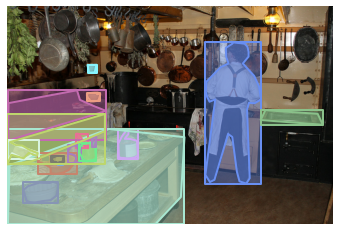

In [39]:
dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(records_path+'*.tfrecord'))
for i in dataset.take(1):
    parse(i)

# 4.3 Feature extraction

In [40]:
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [41]:
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='max')

In [42]:
def extract_features(img_path, model):
    
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    
    expanded_img_array = np.expand_dims(img_array, axis=0)
    
    preprocessed_img = preprocess_input(expanded_img_array)
    
    features = model.predict(preprocessed_img)
    
    normalized_features = features / norm(features)
    
    return normalized_features

In [48]:
features = extract_features('D:/coco_minitrain_25k/coco_minitrain_25k/images/val2017/000000001503.jpg', model)[0]
print(len(features))                       

1/1 [==============================] - 0s 131ms/step
2048


In [49]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [60]:
root_dir = 'D:/coco_minitrain_25k/coco_minitrain_25k/images/train2017/'
filenames = sorted(get_file_list(root_dir))

In [61]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model)[0])

<ipython-input-61-ef67305d5574>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/25000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 133ms/step


KeyboardInterrupt: 

# 4.4 Similarity Search

In [62]:
neighbors = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(feature_list)

In [63]:
def plot_images(paths, title):
    plt.figure(figsize=(20,20))
    for i, path in enumerate(paths):
        plt.subplot(1, len(paths), i+1)
        plt.imshow(mpimg.imread(path))
        plt.axis('off')
        plt.title(f'Distance: {title[i]:.2f}')
    plt.show()

In [64]:
for i in range(0):
    random_image_index = np.random.randint(0,len(filenames))
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1, 1)]
    plot_images(similar_image_paths, distances[0])